<a href="https://colab.research.google.com/github/bielrossi15/generator/blob/master/mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_dir = '/content/drive/MyDrive/DATASETS/archive'
x_real = os.path.join(train_dir, 'Drawings')

In [6]:
dataset = []
for i in glob.glob(x_real+'/*.jpg'):
    img = Image.open(i).resize((256,256))
    dataset.append(np.asarray(img))

KeyboardInterrupt: ignored

In [ ]:
len(dataset)

In [ ]:
dataset = np.reshape(dataset, (len(dataset),256,256,3))
dataset = dataset.astype("float32") / 255.

In [ ]:
BUFFER = dataset.shape[0]
BATCH = 100
train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER).batch(BATCH)

In [ ]:
plt.imshow(dataset[1])

In [7]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5) / 127.5
t_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

# **DISCRIMINATOR**

In [9]:
def discriminator_model(img_shape):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", input_shape=img_shape))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same"))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same"))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

    return model

In [12]:
d_model = discriminator_model((28,28,1))

In [13]:
d_optimizer = tf.optimizers.Adam(1e-3)  

In [14]:
def discriminator_loss(r_pred, f_pred):
    r_pred = tf.sigmoid(r_pred) # [0,1]
    f_pred = tf.sigmoid(f_pred) # [0,1]
    r_loss = tf.losses.binary_crossentropy(tf.ones_like(r_pred),r_pred) # r_pred ~ 1
    f_loss = tf.losses.binary_crossentropy(tf.zeros_like(f_pred),f_pred) # f_pred ~ 0
    return r_loss + f_loss

# **GENERATOR**

In [17]:
def generator_model(seed_size):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(7*7*256, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((7,7,256)))

    print(model.output_shape)

    model.add(tf.keras.layers.Conv2DTranspose(256,5, strides=1,padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    print(model.output_shape)

    model.add(tf.keras.layers.Conv2DTranspose(128,5,strides=2,padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    print(model.output_shape)

    model.add(tf.keras.layers.Conv2DTranspose(64,5,strides=2,padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    print(model.output_shape)

    model.add(tf.keras.layers.Conv2DTranspose(1,5,padding="same"))

    print(model.output_shape)

    return model

In [18]:
g_model = generator_model(100)

(None, 7, 7, 256)
(None, 7, 7, 256)
(None, 14, 14, 128)
(None, 28, 28, 64)
(None, 28, 28, 1)


In [19]:
g_optimizer = tf.optimizers.Adam(1e-3)

In [20]:
def generator_loss(f_pred):
    f_pred = tf.sigmoid(f_pred)
    f_loss = tf.losses.binary_crossentropy(tf.ones_like(f_pred),f_pred) # f_pred ~ 1
    return f_loss

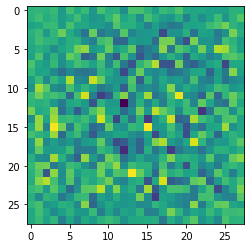

In [21]:
img_generator = g_model(tf.random.normal([1,100]), training=False)
decision = d_model(img_generator)
plt.imshow(img_generator[0, :, :, 0])

# **TRAINING**

In [ ]:
def generate_save(model, epoch, seed):
    pred = model(seed, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(pred.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(pred[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

        plt.show()

In [22]:
def train(dataset,epochs):
    for _ in range(epochs):
        for images in dataset:
            images = tf.cast(images,tf.dtypes.float32)
            train_step(images)

            display.clear_output(wait=True)
            generate_and_save_images(g_model, epoch+1, 100)

            disp

In [23]:
def train_step(images):
    noise = tf.random.normal([256,100])
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        generated_images = g_model(noise, training=True)
        r_out = d_model(images)
        f_out = d_model(generated_images)

        g_loss = generator_loss(f_out)
        d_loss = discriminator_loss(r_out, f_out)

    gen_gradients = g_tape.gradient(g_loss, g_model.trainable_variables)
    disc_gradients = d_tape.gradient(d_loss, d_model.trainable_variables)

    g_optimizer.apply_gradients(zip(gen_gradients, g_model.trainable_variables))
    d_optimizer.apply_gradients(zip(disc_gradients, d_model.trainable_variables))

    print("generator loss: ", np.mean(g_loss))
    print("discriminator loss: ", np.mean(d_loss))

In [24]:
train(t_dataset,1)

generator loss:  0.4732778
discriminator loss:  1.4488616
generator loss:  0.6561024
discriminator loss:  1.1906399
generator loss:  0.6797609
discriminator loss:  1.1186128
generator loss:  0.57231164
discriminator loss:  1.1849649
generator loss:  0.42664707
discriminator loss:  1.411074
generator loss:  0.43091908
discriminator loss:  1.4220703


KeyboardInterrupt: ignored